# Rideshare Service Price Analysis and Prediction

## Group Primrose
### Group Members:
1. Amol Bohora
2. Ayush Shah
3. Sumit Pagar

### Import Libraries

In [193]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
pd.set_option("future.no_silent_downcasting", True)

### Import Data

In [151]:
file_path="data/rideshare_kaggle.csv"
cab_rides_data=pd.read_csv(file_path)

In [152]:
# Display the first few rows of the dataset
cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [153]:
# Display the information about the dataset including the data types of the columns
cab_rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

### Basic Data Validation Checks

In [154]:
# Find the number of missing values in each column of the dataset and the percentage of missing values in each column
missing_values = cab_rides_data.isnull().sum()
missing_percentage = (missing_values / len(cab_rides_data)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Values Report:")
print(missing_info[missing_info['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False))

Missing Values Report:
       Missing Values  Percentage
price           55095    7.949402


In [155]:
# Find the missing values in the 'price' column for each cab company.

missing_values_per_cab_type = cab_rides_data.groupby('cab_type')['price'].apply(lambda x: x.isnull().sum())

print("Missing Values for 'price' by Cab Type:")
print(missing_values_per_cab_type)

Missing Values for 'price' by Cab Type:
cab_type
Lyft        0
Uber    55095
Name: price, dtype: int64


In [156]:
# Find the missing values in the 'price' column for each cab company.
missing_values_per_cab_type = cab_rides_data.groupby('cab_type')['price'].apply(lambda x: x.isnull().sum())

print("Missing Values for 'price' by Cab Type:")
print(missing_values_per_cab_type)


Missing Values for 'price' by Cab Type:
cab_type
Lyft        0
Uber    55095
Name: price, dtype: int64


In [157]:
# To  substitute the missing values in the 'price' column with the mean price for that cab type
cab_rides_data['time_slot'] = (cab_rides_data['hour'] // 2) * 2  # e.g., 0-1 becomes 0, 2-3 becomes 2

# Calculate the mean price for each 2-hour time slot
slot_mean_price = cab_rides_data.groupby(['time_slot','cab_type'])['price'].mean()

# Impute missing prices with the mean price of their respective time slot
cab_rides_data['price'] = cab_rides_data.apply(
    lambda row: slot_mean_price.get((row['time_slot'], row['cab_type']), row['price'])
    if pd.isnull(row['price']) else row['price'],
    axis=1
)
cab_rides_data

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,time_slot
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000,8
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600,2
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000,0
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800,4
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693066,616d3611-1820-450a-9845-a9ff304a4842,1.543708e+09,23,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,...,1543683600,31.42,1543658400,44.76,1543690800,27.77,1543658400,44.09,1543690800,22
693067,633a3fc3-1f86-4b9e-9d48-2b7132112341,1.543708e+09,23,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,...,1543683600,31.42,1543658400,44.76,1543690800,27.77,1543658400,44.09,1543690800,22
693068,64d451d0-639f-47a4-9b7c-6fd92fbd264f,1.543708e+09,23,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,...,1543683600,31.42,1543658400,44.76,1543690800,27.77,1543658400,44.09,1543690800,22
693069,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,1.543708e+09,23,1,12,2018-12-01 23:53:05,America/New_York,West End,North End,Uber,...,1543683600,31.42,1543658400,44.76,1543690800,27.77,1543658400,44.09,1543690800,22


In [158]:
missing_values_per_cab_type=cab_rides_data.groupby('cab_type')['price'].apply(lambda x:x.isnull().sum())
missing_values_per_cab_type

cab_type
Lyft    0
Uber    0
Name: price, dtype: int64

### Formatting Data

In [159]:
# Create a new column 'is_rain' that indicates whether it was raining or not during the ride
cab_rides_data['is_rain'] = cab_rides_data['short_summary'].str.contains('rain', case=False).astype(int)

In [160]:
#sorting by datetime column
cab_rides_data = cab_rides_data.sort_values(by='datetime')

In [161]:
# Format datetime
cab_rides_data['datetime'] = pd.to_datetime(cab_rides_data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [162]:
# Split Date and Time
cab_rides_data['date'] = cab_rides_data['datetime'].dt.date
cab_rides_data['time'] = cab_rides_data['datetime'].dt.time
cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,time_slot,is_rain,date,time
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,46.15,1543154400,38.23,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,46.15,1543154400,38.23,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,46.15,1543154400,38.23,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,46.15,1543154400,38.23,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,46.15,1543154400,38.23,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46


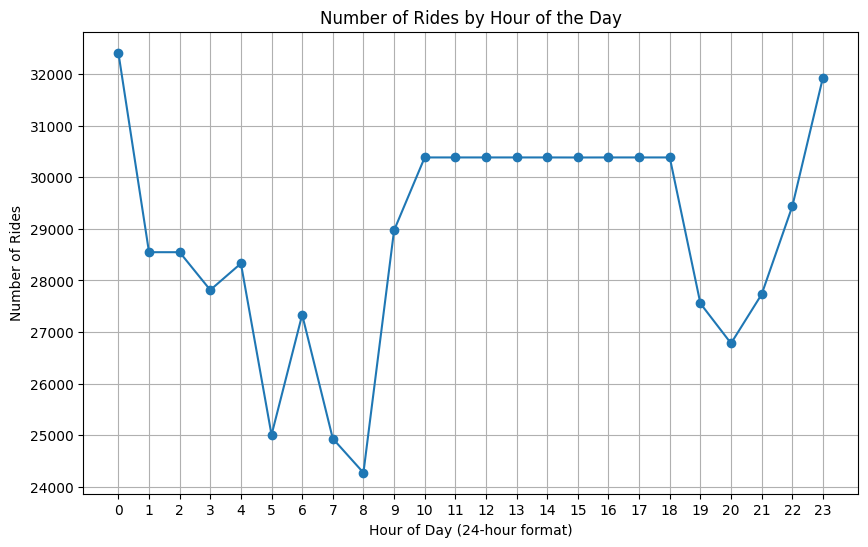

In [163]:
# Extract hour of the day for grouping
cab_rides_data['hour_of_day'] = cab_rides_data['datetime'].dt.hour

# Group by hour of day and calculate the total rides
rides_per_hour_of_day = cab_rides_data.groupby('hour_of_day').size().reset_index(name='rides_count')

# Plot the number of rides per hour of the day
plt.figure(figsize=(10, 6))
plt.plot(rides_per_hour_of_day['hour_of_day'], rides_per_hour_of_day['rides_count'], marker='o')
plt.title('Number of Rides by Hour of the Day')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Rides')
plt.grid()
plt.xticks(range(0, 24))
plt.show()


In [164]:
# Create "odd_time" column
cab_rides_data['odd_time'] = cab_rides_data['time'].apply(lambda x: 1 if x.hour < 6 else 0)

# Create "peak_time" column
cab_rides_data['peak_time'] = cab_rides_data['time'].apply(lambda x: 1 if (8 <= x.hour <= 10) or (
            16 <= x.hour <= 19) else 0)

# Print the updated dataframe
cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,time_slot,is_rain,date,time,hour_of_day,odd_time,peak_time
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,1543136400,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0


In [165]:
# Add a column which stores was the ride taken in day or night
cab_rides_data['is_night'] = cab_rides_data.apply(
    lambda row: not (row['sunriseTime'] <= row['datetime'].timestamp() <= row['sunsetTime']),
    axis=1
)

# Print the updated DataFrame
cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,apparentTemperatureMax,apparentTemperatureMaxTime,time_slot,is_rain,date,time,hour_of_day,odd_time,peak_time,is_night
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True


In [166]:
# Rename column 'cab_type' to 'cab_company', 'name' to 'cab_type', 'odd_time' to 'odd_time_of_travel' of cab_rides_data
cab_rides_data.rename(columns={
    'cab_type': 'cab_company',
    'odd_time': 'odd_time_of_travel'
}, inplace=True)

cab_rides_data.rename(columns={
    'name': 'cab_type'
}, inplace=True)

# Display the first few rows of the dataset
cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_company,...,apparentTemperatureMax,apparentTemperatureMaxTime,time_slot,is_rain,date,time,hour_of_day,odd_time_of_travel,peak_time,is_night
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,43.17,1543186800,2,0,2018-11-26,03:40:46,3,1,0,True


In [167]:
# Create a new column 'day_of_week' that indicates the day of the week for each ride
cab_rides_data['day_of_week'] = cab_rides_data['datetime'].dt.day_name()

In [168]:
# Create "is_weekend" column that indicates whether the ride was on a weekend or not
cab_rides_data['is_weekend'] = cab_rides_data['day_of_week'].apply(lambda x: 1 if x=="Saturday" or x=="Sunday" else 0)
cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_company,...,time_slot,is_rain,date,time,hour_of_day,odd_time_of_travel,peak_time,is_night,day_of_week,is_weekend
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,2,0,2018-11-26,03:40:46,3,1,0,True,Monday,0
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,2,0,2018-11-26,03:40:46,3,1,0,True,Monday,0
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,2,0,2018-11-26,03:40:46,3,1,0,True,Monday,0
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,2,0,2018-11-26,03:40:46,3,1,0,True,Monday,0
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,2,0,2018-11-26,03:40:46,3,1,0,True,Monday,0


In [169]:
# Convert 0 to False and 1 to True in the specified columns
columns_to_convert = ['peak_time', 'is_weekend', 'odd_time_of_travel', 'is_rain']

cab_rides_data[columns_to_convert] = cab_rides_data[columns_to_convert].apply(
    lambda col: col.replace({0: False, 1: True}).astype(bool)
)

cab_rides_data.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_company,...,time_slot,is_rain,date,time,hour_of_day,odd_time_of_travel,peak_time,is_night,day_of_week,is_weekend
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,2,False,2018-11-26,03:40:46,3,True,False,True,Monday,False
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,2,False,2018-11-26,03:40:46,3,True,False,True,Monday,False
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,2,False,2018-11-26,03:40:46,3,True,False,True,Monday,False
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,2,False,2018-11-26,03:40:46,3,True,False,True,Monday,False
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,2,False,2018-11-26,03:40:46,3,True,False,True,Monday,False


In [170]:
# Cleanup before selecting data
cab_rides_data['year'] = cab_rides_data['datetime'].dt.year
cab_rides_data['month'] = cab_rides_data['datetime'].dt.month
cab_rides_data['day'] = cab_rides_data['datetime'].dt.day
cab_rides_data['hour'] = cab_rides_data['datetime'].dt.hour
cab_rides_data['minute'] = cab_rides_data['datetime'].dt.minute
cab_rides_data['weekday'] = cab_rides_data['datetime'].dt.weekday

# Ensure boolean columns are explicitly cast to boolean type
cab_rides_data['is_night'] = cab_rides_data['is_night'].astype(bool)
cab_rides_data['is_rain'] = cab_rides_data['is_rain'].astype(bool)
cab_rides_data['is_weekend'] = cab_rides_data['is_weekend'].astype(bool)

cab_rides_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 693071 entries, 66422 to 166551
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           693071 non-null  object        
 1   timestamp                    693071 non-null  float64       
 2   hour                         693071 non-null  int32         
 3   day                          693071 non-null  int32         
 4   month                        693071 non-null  int32         
 5   datetime                     693071 non-null  datetime64[ns]
 6   timezone                     693071 non-null  object        
 7   source                       693071 non-null  object        
 8   destination                  693071 non-null  object        
 9   cab_company                  693071 non-null  object        
 10  product_id                   693071 non-null  object        
 11  cab_type                   

In [190]:
## Create a DF of selected features

In [172]:
columns_to_include = [
    'source', 'destination', 'cab_company', 'cab_type', 'price', 'distance',
    'surge_multiplier', 'apparentTemperature', 'precipIntensity',
    'visibility.1', 'precipIntensityMax', 'day', 'month', 'hour', 'minute',
]

selected_features = cab_rides_data[columns_to_include]
selected_features.info()


<class 'pandas.core.frame.DataFrame'>
Index: 693071 entries, 66422 to 166551
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   source               693071 non-null  object 
 1   destination          693071 non-null  object 
 2   cab_company          693071 non-null  object 
 3   cab_type             693071 non-null  object 
 4   price                693071 non-null  float64
 5   distance             693071 non-null  float64
 6   surge_multiplier     693071 non-null  float64
 7   apparentTemperature  693071 non-null  float64
 8   precipIntensity      693071 non-null  float64
 9   visibility.1         693071 non-null  float64
 10  precipIntensityMax   693071 non-null  float64
 11  day                  693071 non-null  int32  
 12  month                693071 non-null  int32  
 13  hour                 693071 non-null  int32  
 14  minute               693071 non-null  int32  
dtypes: float64(7), int

### Visualization

In [173]:
# Create a deep copy of the dataset for visualisation
cab_rides_data_for_visualisation =cab_rides_data.copy(deep=True)
cab_rides_data_for_visualisation.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_company,...,time,hour_of_day,odd_time_of_travel,peak_time,is_night,day_of_week,is_weekend,year,minute,weekday
66422,a7b50600-c6c5-4e6c-bea9-4487344196d4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North Station,Haymarket Square,Uber,...,03:40:46,3,True,False,True,Monday,False,2018,40,0
446073,9962f244-8fce-4ae9-a583-139d5d7522e1,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Theatre District,North End,Uber,...,03:40:46,3,True,False,True,Monday,False,2018,40,0
184332,4aa68a5d-abc0-4fdf-a47f-0003617afbae,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,03:40:46,3,True,False,True,Monday,False,2018,40,0
167114,ef8b695c-c24d-4ac1-b3fe-4aa1a7ed79f4,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,Boston University,Beacon Hill,Lyft,...,03:40:46,3,True,False,True,Monday,False,2018,40,0
184333,89f35ef7-7129-483d-b3e6-d89afdf6946d,1.543204e+09,3,26,11,2018-11-26 03:40:46,America/New_York,North End,West End,Lyft,...,03:40:46,3,True,False,True,Monday,False,2018,40,0


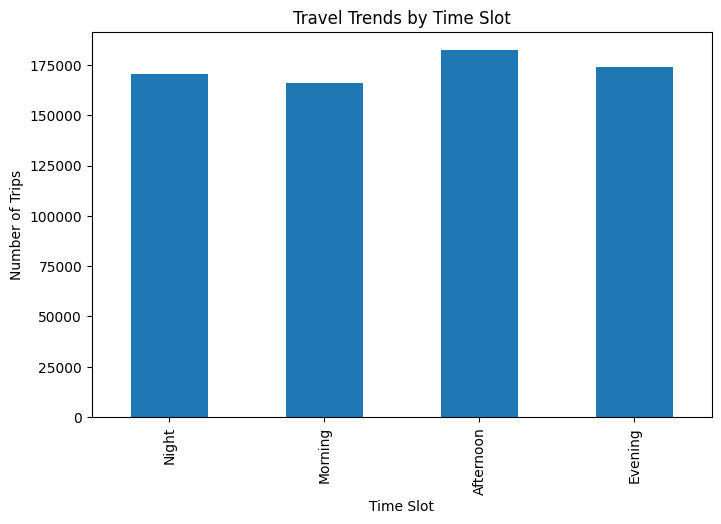

In [174]:
# Create a graph to visualize the distribution of rides

cab_rides_data_for_visualisation['time_slot'] = pd.cut(cab_rides_data_for_visualisation['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
time_slot_counts = cab_rides_data_for_visualisation['time_slot'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
time_slot_counts.plot(kind='bar', title='Travel Trends by Time Slot')
plt.xlabel('Time Slot')
plt.ylabel('Number of Trips')
plt.show()

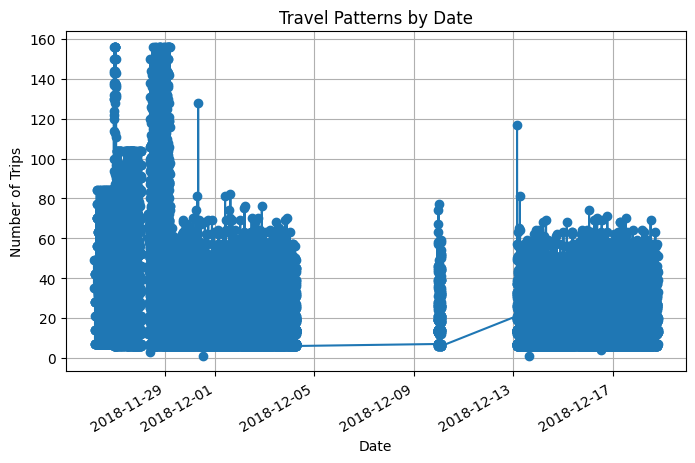

In [175]:
# Plot Travel Patterns
date_counts = cab_rides_data_for_visualisation['datetime'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
date_counts.plot(kind='line', marker='o', title='Travel Patterns by Date')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid()
plt.show()

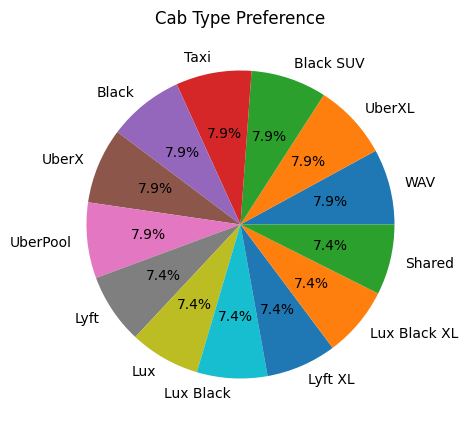

In [176]:
# Create a graph to visualize the distribution of rides by cab type
cab_type_counts = cab_rides_data_for_visualisation['cab_type'].value_counts()

plt.figure(figsize=(8, 5))
cab_type_counts.plot(kind='pie', autopct='%1.1f%%', title='Cab Type Preference')
plt.ylabel('')
plt.show()

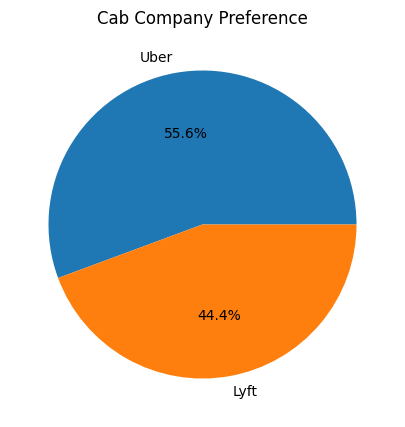

In [177]:
# Create a graph to visualize the distribution of rides by cab company
cab_company_counts = cab_rides_data_for_visualisation['cab_company'].value_counts()

plt.figure(figsize=(8, 5))
cab_company_counts.plot(kind='pie', autopct='%1.1f%%', title='Cab Company Preference')
plt.ylabel('')
plt.show()

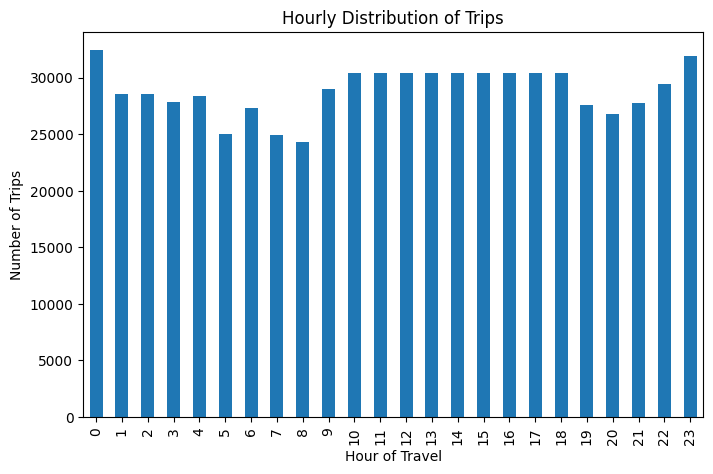

In [178]:
# Hourly Distribution of Trips by Hour of Travel
hourly_counts = cab_rides_data_for_visualisation['hour'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
hourly_counts.plot(kind='bar', title='Hourly Distribution of Trips')
plt.xlabel('Hour of Travel')
plt.ylabel('Number of Trips')
plt.show()

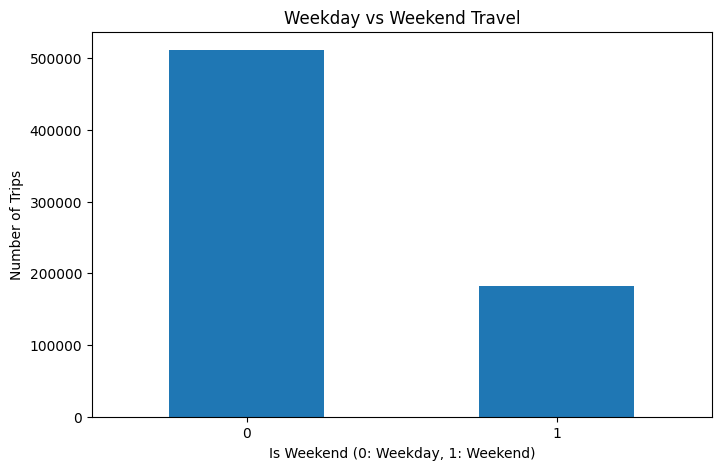

In [179]:
# Visualize the distribution of rides by the week or weekend

cab_rides_data_for_visualisation['weekday'] = pd.to_datetime(cab_rides_data_for_visualisation['date']).dt.dayofweek
cab_rides_data_for_visualisation['is_weekend'] = cab_rides_data_for_visualisation['weekday'].apply(lambda x: 1 if x >= 5 else 0)
weekday_counts = cab_rides_data_for_visualisation.groupby('is_weekend')['hour'].count()

plt.figure(figsize=(8, 5))
weekday_counts.plot(kind='bar', title='Weekday vs Weekend Travel')
plt.xlabel('Is Weekend (0: Weekday, 1: Weekend)')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.show()

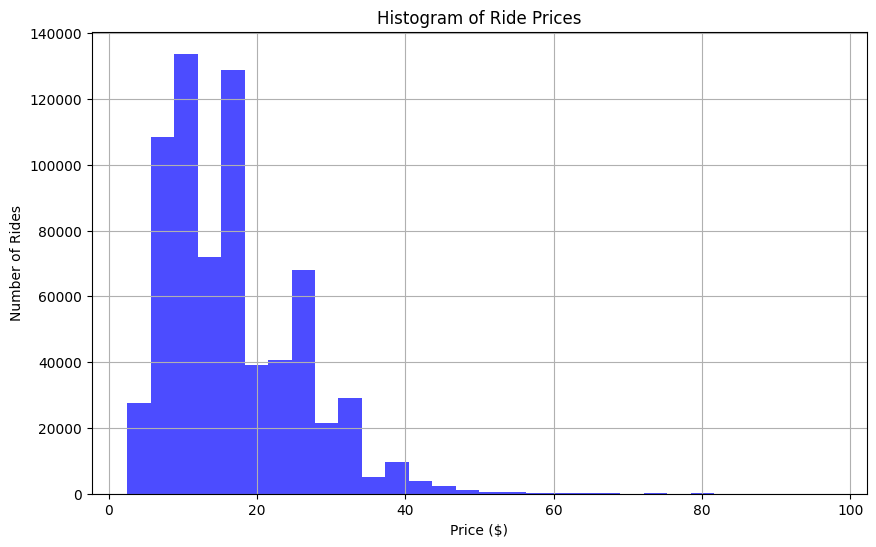

In [180]:
# Creating a histogram of ride prices
plt.figure(figsize=(10, 6))
plt.hist(cab_rides_data_for_visualisation['price'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Ride Prices')
plt.xlabel('Price ($)')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.show()

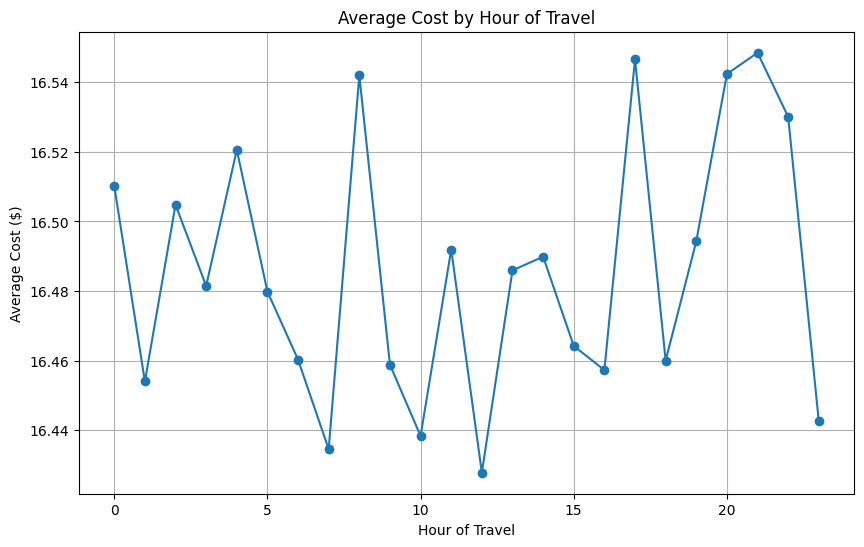

In [181]:
# Avg cost of travel by the hour when the ride was taken
average_cost_by_hour = cab_rides_data_for_visualisation.groupby('hour')['price'].mean()

# 2. Identify peak and low-cost hours
peak_cost_hour = average_cost_by_hour.idxmax()
peak_cost_value = average_cost_by_hour.max()

low_cost_hour = average_cost_by_hour.idxmin()
low_cost_value = average_cost_by_hour.min()

# 3. Visualize average cost across hours
plt.figure(figsize=(10, 6))
average_cost_by_hour.plot(kind='line', marker='o', title='Average Cost by Hour of Travel')
plt.xlabel('Hour of Travel')
plt.ylabel('Average Cost ($)')
plt.grid()
plt.show()

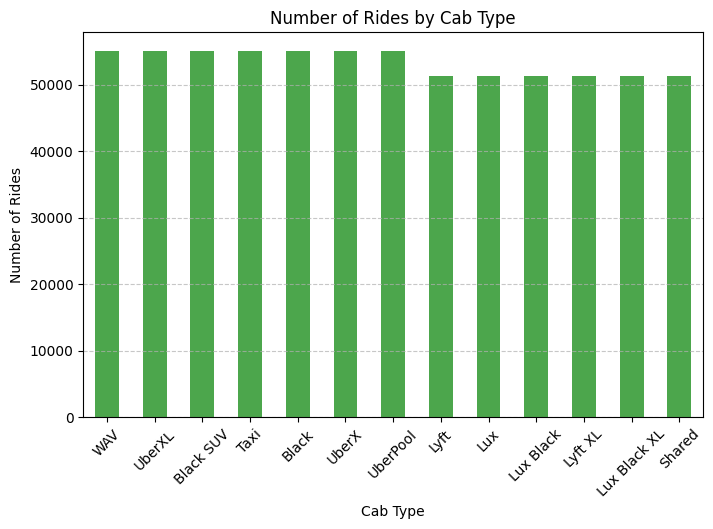

In [182]:
# Creating a bar chart of cab types
cab_type_counts = cab_rides_data_for_visualisation['cab_type'].value_counts()

plt.figure(figsize=(8, 5))
cab_type_counts.plot(kind='bar', color='green', alpha=0.7)
plt.title('Number of Rides by Cab Type')
plt.xlabel('Cab Type')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

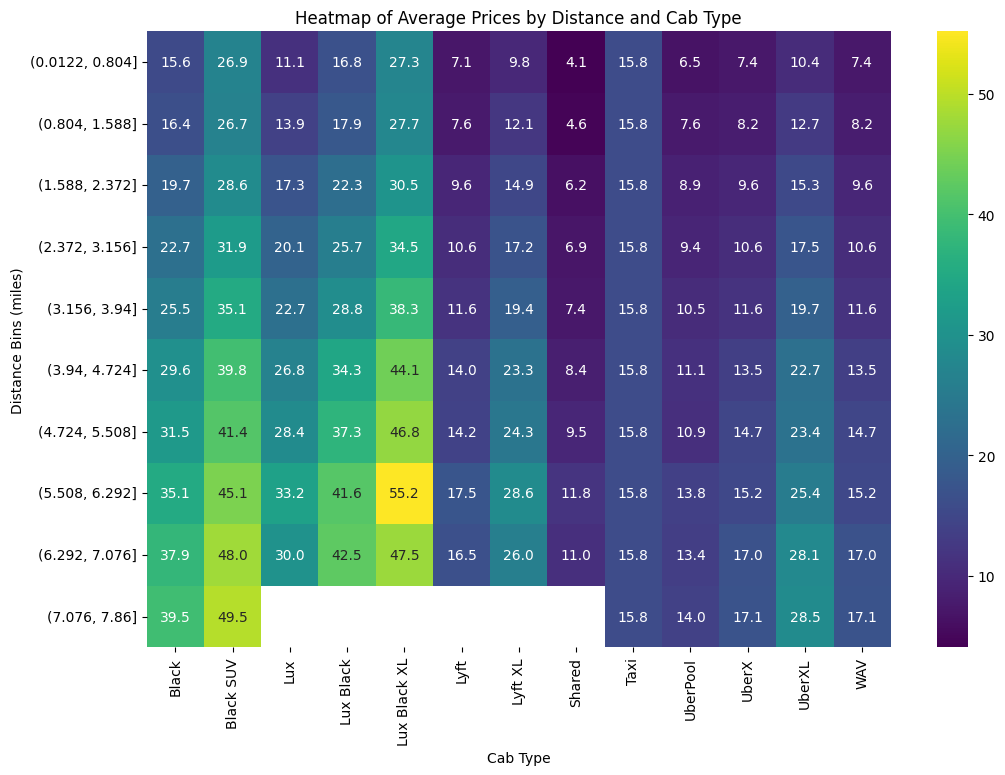

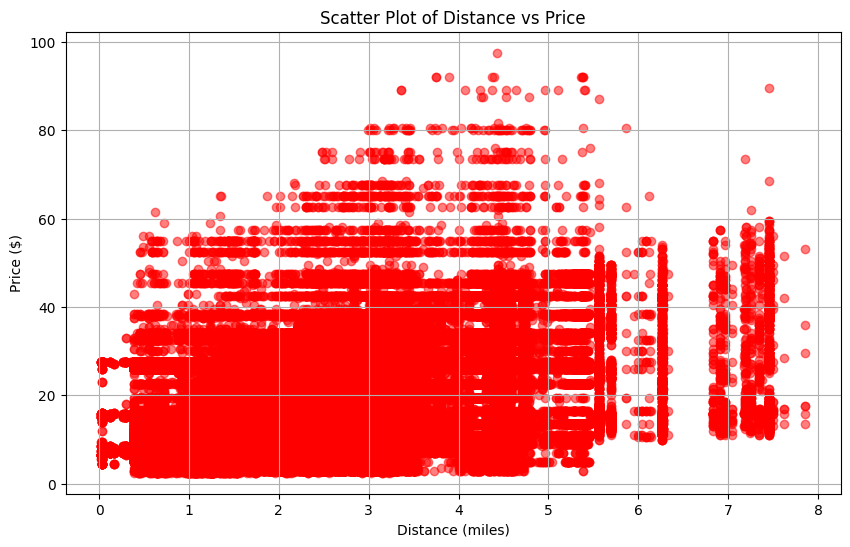

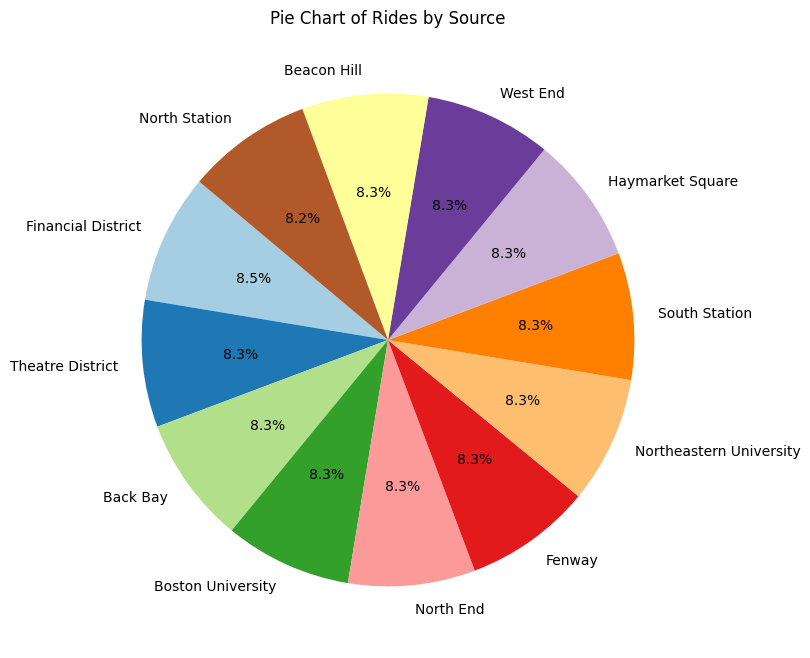

,total_rides,average_price,average_distance,average_surge
cab_type,,,,
Black,55095,20.523786,2.191399,1.000000
Black SUV,55096,30.286763,2.191378,1.000000
Lux,51235,17.771240,2.186968,1.037177
Lux Black,51235,23.062468,2.186968,1.037177
Lux Black XL,51235,32.324086,2.186968,1.037177
Lyft,51235,9.610885,2.186968,1.038045
Lyft XL,51235,15.309363,2.186968,1.038045
Shared,51233,6.029893,2.187012,1.000000
Taxi,55095,15.795334,2.191383,1.000000


In [183]:
# Creating Heatmap of Average Prices by Distance and Cab Type

# Creating distance bins for better visualization
cab_rides_data_for_visualisation['distance_bins'] = pd.cut(cab_rides_data_for_visualisation['distance'], bins=10)

# Creating a pivot table to analyze prices across distances and cab types
price_heatmap_data = cab_rides_data_for_visualisation.pivot_table(
    values='price',
    index='distance_bins',
    columns='cab_type',
    aggfunc="mean",
    observed=False
)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
plt.title('Heatmap of Average Prices by Distance and Cab Type')
sns.heatmap(price_heatmap_data, annot=True, fmt=".1f", cmap='viridis')
plt.xlabel('Cab Type')
plt.ylabel('Distance Bins (miles)')
plt.show()
# Creating a scatter plot of distance vs price
plt.figure(figsize=(10, 6))
plt.scatter(cab_rides_data_for_visualisation['distance'], cab_rides_data_for_visualisation['price'], alpha=0.5, color='red')
plt.title('Scatter Plot of Distance vs Price')
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

# Creating a pie chart of rides by source
source_counts = cab_rides_data_for_visualisation['source'].value_counts()

plt.figure(figsize=(10, 8))
source_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Pie Chart of Rides by Source')
plt.ylabel('')  # Removing the y-label as it's unnecessary for pie charts
plt.show()

# Grouping data by cab type to calculate the requested metrics
lyft_uber_analysis = cab_rides_data_for_visualisation.groupby('cab_type').agg(
    total_rides=('id', 'count'),
    average_price=('price', 'mean'),
    average_distance=('distance', 'mean'),
    average_surge=('surge_multiplier', 'mean')
)

lyft_uber_analysis

### Encode Labels for Model Training

In [184]:
label_encoder = preprocessing.LabelEncoder()
# Create a list of columns to encode
golden_data = selected_features.copy()
cols_to_encode = [col for col in golden_data.columns if col not in ['price']]

# Apply label encoding to each column
for col in cols_to_encode:
    golden_data[col] = label_encoder.fit_transform(golden_data[col])

    # Get the mapping from encoded values to original names
    mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

    # Print the mapping for the column
    print(f"Mapping for {col} column:")
    print(mapping,"\n")

Mapping for source column:
{np.int64(0): 'Back Bay', np.int64(1): 'Beacon Hill', np.int64(2): 'Boston University', np.int64(3): 'Fenway', np.int64(4): 'Financial District', np.int64(5): 'Haymarket Square', np.int64(6): 'North End', np.int64(7): 'North Station', np.int64(8): 'Northeastern University', np.int64(9): 'South Station', np.int64(10): 'Theatre District', np.int64(11): 'West End'} 

Mapping for destination column:
{np.int64(0): 'Back Bay', np.int64(1): 'Beacon Hill', np.int64(2): 'Boston University', np.int64(3): 'Fenway', np.int64(4): 'Financial District', np.int64(5): 'Haymarket Square', np.int64(6): 'North End', np.int64(7): 'North Station', np.int64(8): 'Northeastern University', np.int64(9): 'South Station', np.int64(10): 'Theatre District', np.int64(11): 'West End'} 

Mapping for cab_company column:
{np.int64(0): 'Lyft', np.int64(1): 'Uber'} 

Mapping for cab_type column:
{np.int64(0): 'Black', np.int64(1): 'Black SUV', np.int64(2): 'Lux', np.int64(3): 'Lux Black', np.int

In [185]:
golden_data

,source,destination,cab_company,cab_type,price,distance,surge_multiplier,apparentTemperature,precipIntensity,visibility.1,precipIntensityMax,day,month,hour,minute
66422,7,5,1,10,7.000000,27,0,248,0,6,55,12,0,3,40
446073,10,6,1,8,15.830582,128,0,248,0,6,55,12,0,3,40
184332,6,11,0,5,7.000000,94,0,248,0,6,55,12,0,3,40
167114,2,1,0,2,19.500000,237,0,248,0,6,55,12,0,3,40
184333,6,11,0,7,5.000000,94,0,248,0,6,55,12,0,3,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34918,4,5,1,10,7.000000,96,0,23,0,167,7,11,1,19,15
215397,3,10,1,1,33.500000,237,0,23,0,167,7,11,1,19,15
166550,5,0,1,10,11.500000,201,0,23,0,167,7,11,1,19,15
290785,8,1,0,4,34.000000,271,0,23,0,167,7,11,1,19,15


### Creating Train and Test Data


In [186]:
target = 'price'

# Create feature matrix (X) and target vector (y)
X= golden_data.drop('price', axis=1)
y= golden_data['price']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (554456, 14)
X_test shape: (138615, 14)


### Linear Regression Model


In [201]:
# Linear Regression
# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
print("Linear Regression Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_linear))
print("Mean Absolute Error(MAE):", mean_absolute_error(y_test, y_pred_linear))
print("R-squared (R2):", r2_score(y_test, y_pred_linear))
mape = mean_absolute_percentage_error(y_test, y_pred_linear) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
accuracy = r2_score(y_test, y_pred_linear) * 100
print(f"Model Accuracy (based on R²): {accuracy:.2f}%")

Linear Regression Results:
Mean Squared Error (MSE): 39.642631412008164
Mean Absolute Error(MAE): 4.933013266600891
R-squared (R2): 0.5031924291020817
Mean Absolute Percentage Error (MAPE): 37.84%
Model Accuracy (based on R²): 50.32%


### Random Forest Model


In [195]:
# Train the Random Forest model
random_forest_model = RandomForestRegressor(random_state=42, max_depth=20)
random_forest_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest_model.predict(X_test)

# Evaluate the model
print("Random Forest Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_rf))
print("R-squared (R2):", r2_score(y_test, y_pred_rf))
mape = mean_absolute_percentage_error(y_test, y_pred_rf) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
accuracy = r2_score(y_test, y_pred_rf) * 100
print(f"Model Accuracy (based on R²): {accuracy:.2f}%")

Random Forest Regressor Results:
Mean Squared Error (MSE): 2.668005624619269
R-squared (R2): 0.9665641420284835
Mean Absolute Percentage Error (MAPE): 7.37%
Model Accuracy (based on R²): 96.66%


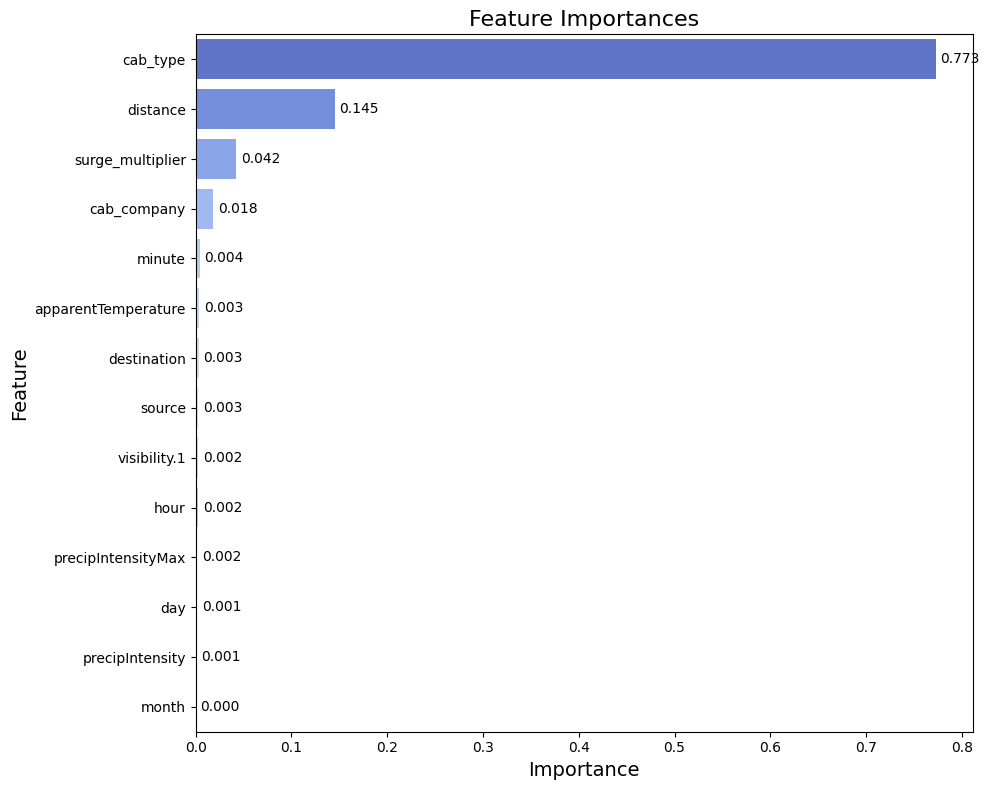

In [197]:
# PLot the feature importances of the Random Forest model
importances = random_forest_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=feature_importances['Importance'],
    y=feature_importances['Feature'],
    palette='coolwarm'  ,
    hue=feature_importances['Feature'],  
    dodge=False,  
    legend=False
)
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
for i, v in enumerate(feature_importances['Importance']):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)
plt.tight_layout()
plt.show()

### Decision Tree Regressor


In [219]:
# Train the Decision Tree Regressor model
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)
y_pred_dt = decision_tree_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_dt)
mse = mean_squared_error(y_test, y_pred_dt)
r2 = r2_score(y_test, y_pred_dt)
# Evaluate the model
print("Decision Tree Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred_dt))
print("R-squared (R2):", r2_score(y_test, y_pred_dt))
mape = mean_absolute_percentage_error(y_test, y_pred_dt) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
accuracy = r2_score(y_test, y_pred_dt) * 100
print(f"Model Accuracy (based on R²): {accuracy:.2f}%")

Decision Tree Regressor Results:
Mean Squared Error (MSE): 2.7755468749970453
R-squared (R2): 0.9652164184927718
Mean Absolute Percentage Error (MAPE): 7.61%
Model Accuracy (based on R²): 96.52%


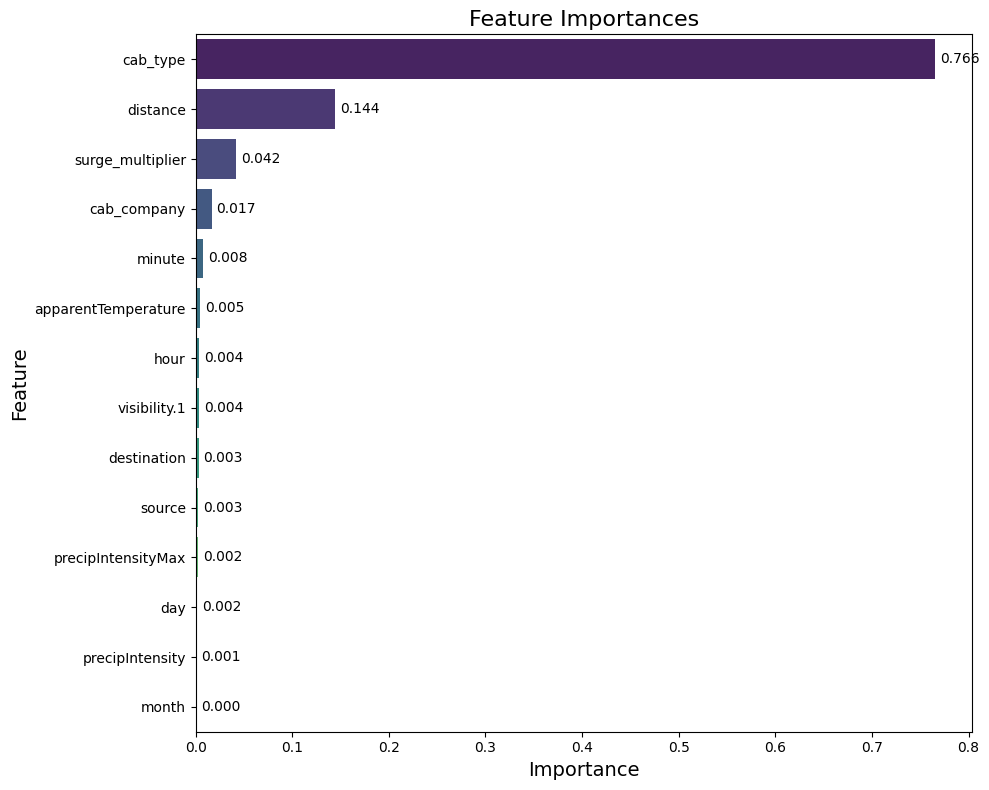

In [220]:
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feature_importances['Importance'],
    y=feature_importances['Feature'],
    palette='viridis',
    hue=feature_importances['Feature'],  
    dodge=False,  
    legend=False
)
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
# Add annotations to each bar
for i, v in enumerate(feature_importances['Importance']):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


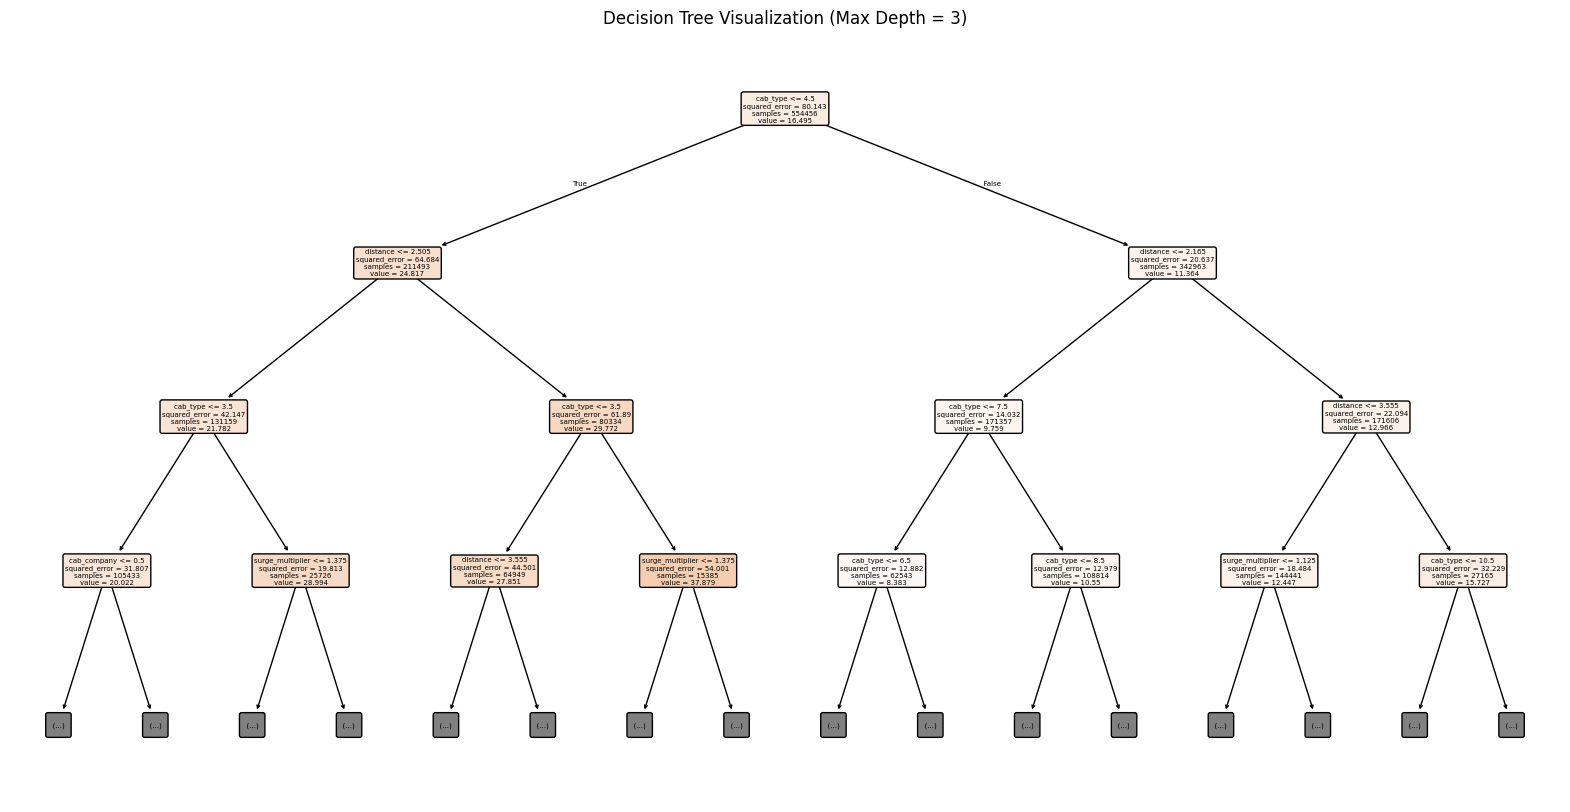

In [221]:
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, feature_names=X_train.columns, filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Max Depth = 3)")
plt.show()

### Model Comparisons


In [206]:
# Compare the models
print("Model Comparison:")
print("Linear Regression - MSE:", mean_squared_error(y_test, y_pred_linear), "| R2:", r2_score(y_test, y_pred_linear))
print("Random Forest Regressor - MSE:", mean_squared_error(y_test, y_pred_rf), "| R2:", r2_score(y_test, y_pred_rf))
print("Decision Tree Regressor - MSE:", mean_squared_error(y_test, y_pred_dt), "| R2:", r2_score(y_test, y_pred_dt))


Model Comparison:
Linear Regression - MSE: 39.642631412008164 | R2: 0.5031924291020817
Random Forest Regressor - MSE: 2.668005624619269 | R2: 0.9665641420284835
Decision Tree Regressor - MSE: 5.207165249251525 | R2: 0.9347430020005916


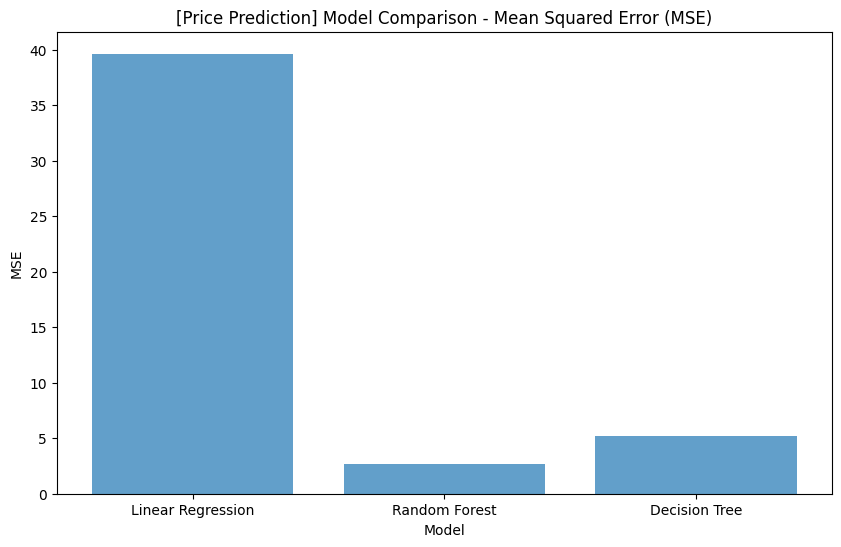

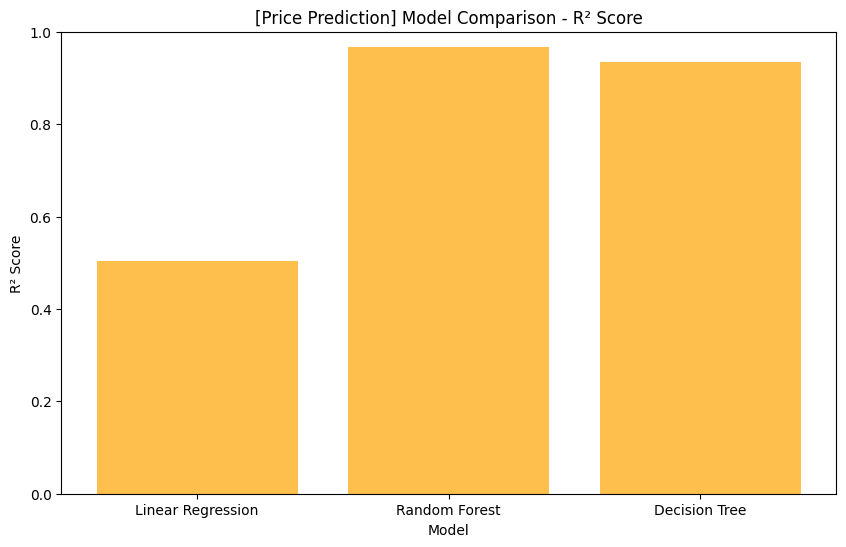

In [207]:

# Define the models
models = ['Linear Regression', 'Random Forest', 'Decision Tree']

# Calculate MSE and R² values
mse_values = [
    mean_squared_error(y_test, y_pred_linear),
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_dt)
]
r2_values = [
    r2_score(y_test, y_pred_linear),
    r2_score(y_test, y_pred_rf),
    r2_score(y_test, y_pred_dt)
]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, alpha=0.7, label='MSE')
plt.title('[Price Prediction] Model Comparison - Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.xticks(models)
plt.show()

# Plot the R² values
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, alpha=0.7, color='orange', label='R² Score')
plt.title('[Price Prediction] Model Comparison - R² Score')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.xticks(models)
plt.ylim(0, 1)  # R² ranges from 0 to 1
plt.show()

### Splitting dataset into different cab company types

In [ ]:
# split selected features into different cab company types

uber_data_df = selected_features[selected_features['cab_company'] == 'Uber'].copy(deep=True)
lyft_data_df = selected_features[selected_features['cab_company'] == 'Lyft'].copy(deep=True)
uber_data_df.drop(['cab_company'], axis=1, inplace=True)
lyft_data_df.drop(['cab_company'], axis=1, inplace=True)

### Uber Models

In [ ]:
# Create a list of columns to encode
cols_to_encode = [col for col in uber_data_df.columns if col not in ['price']]

# Apply label encoding to each column
for col in cols_to_encode:
    uber_data_df[col] = label_encoder.fit_transform(uber_data_df[col])

    # Get the mapping from encoded values to original names
    mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

uber_data_df

,source,destination,cab_type,price,distance,surge_multiplier,apparentTemperature,precipIntensity,visibility.1,precipIntensityMax,day,month,hour,minute
66422,7,5,4,7.000000,19,0,248,0,6,55,12,0,3,40
446073,10,6,2,15.830582,108,0,248,0,6,55,12,0,3,40
32121,7,3,6,10.500000,255,0,248,0,6,55,12,0,3,40
613927,10,3,4,19.500000,222,0,248,0,6,55,12,0,3,40
613926,10,3,5,32.000000,222,0,248,0,6,55,12,0,3,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204548,10,3,2,15.805276,217,0,23,0,167,7,11,1,19,15
34918,4,5,4,7.000000,76,0,23,0,167,7,11,1,19,15
215397,3,10,1,33.500000,217,0,23,0,167,7,11,1,19,15
166550,5,0,4,11.500000,181,0,23,0,167,7,11,1,19,15


In [ ]:
target = 'price'
# Create feature matrix (X) and target vector (y)
X_uber = uber_data_df.drop('price', axis=1)
y_uber = uber_data_df['price']

# Convert categorical columns (e.g., is_rain, day_of_week) to numerical values
# X = pd.get_dummies(X, columns=['day_of_week', 'is_weekend'], drop_first=True)

# Split the dataset into training and testing sets
X_train_uber, X_test_uber, y_train_uber, y_test_uber = train_test_split(X_uber, y_uber, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
print("X_train shape:", X_train_uber.shape)
print("X_test shape:", X_test_uber.shape)

X_train shape: (308530, 13)
X_test shape: (77133, 13)


### Linear Regression Model for Uber


In [212]:
# Linear Regression for Uber
# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_uber, y_train_uber)

# Predict on the test set
y_pred_linear_uber = linear_model.predict(X_test_uber)

# Evaluate the model
print("Linear Regression Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_uber, y_pred_linear_uber))
print("R-squared (R2):", r2_score(y_test_uber, y_pred_linear_uber))
mape = mean_absolute_percentage_error(y_test_uber, y_pred_linear_uber) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
accuracy = r2_score(y_test_uber, y_pred_linear_uber) * 100
print(f"Model Accuracy (based on R²): {accuracy:.2f}%")


Linear Regression Results:
Mean Squared Error (MSE): 33.60441420310319
R-squared (R2): 0.4650209982259109
Mean Absolute Percentage Error (MAPE): 33.75%
Model Accuracy (based on R²): 46.50%


### Random Forest Model for Uber


In [213]:
# Train the Random Forest model
random_forest_model_uber = RandomForestRegressor(random_state=42, max_depth=20)
random_forest_model_uber.fit(X_train_uber, y_train_uber)

# Predict on the test set
y_pred_rf_uber = random_forest_model_uber.predict(X_test_uber)

# Evaluate the model
print("Random Forest Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_uber, y_pred_rf_uber))
print("R-squared (R2):", r2_score(y_test_uber, y_pred_rf_uber))
mape = mean_absolute_percentage_error(y_test_uber, y_pred_rf_uber) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
accuracy = r2_score(y_test_uber, y_pred_rf_uber) * 100
print(f"Model Accuracy (based on R²): {accuracy:.2f}%")


Random Forest Regressor Results:
Mean Squared Error (MSE): 3.3024890916269998
R-squared (R2): 0.9474246952519327
Mean Absolute Percentage Error (MAPE): 7.16%
Model Accuracy (based on R²): 94.74%


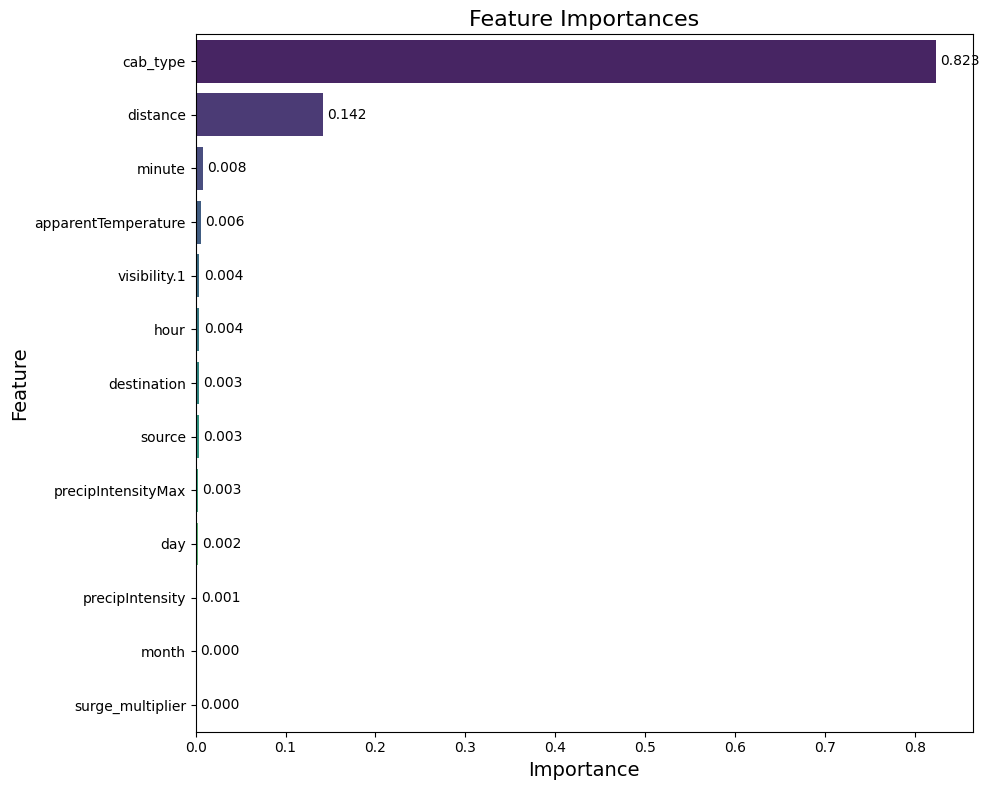

In [222]:
# Get feature importances and sort them in descending order
importances_uber = random_forest_model_uber.feature_importances_
feature_names_uber = X_uber.columns
feature_importances_uber = pd.DataFrame({'Feature': feature_names_uber, 'Importance': importances_uber})
feature_importances_uber = feature_importances_uber.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feature_importances_uber['Importance'],
    y=feature_importances_uber['Feature'],
    palette='viridis' ,
    hue=feature_importances_uber['Feature'],
    dodge=False,
    legend=False
)
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
# Add annotations to each bar
for i, v in enumerate(feature_importances_uber['Importance']):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Decision Tree Regressor for Uber


In [223]:
# Decision Tree Regressor for Uber
dt_model_uber = DecisionTreeRegressor(random_state=42)
dt_model_uber.fit(X_train_uber, y_train_uber)
y_pred_dt_uber = dt_model_uber.predict(X_test_uber)

# Evaluate the model
print("Decision Tree Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_uber, y_pred_dt_uber))
print("R-squared (R2):", r2_score(y_test_uber, y_pred_dt_uber))
mape = mean_absolute_percentage_error(y_test_uber, y_pred_dt_uber) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
accuracy = r2_score(y_test_uber, y_pred_dt_uber) * 100
print(f"Model Accuracy (based on R²): {accuracy:.2f}%")




Decision Tree Regressor Results:
Mean Squared Error (MSE): 6.546888864940355
R-squared (R2): 0.8957741667947821
Mean Absolute Percentage Error (MAPE): 9.77%
Model Accuracy (based on R²): 89.58%


### Uber Model Evaluations

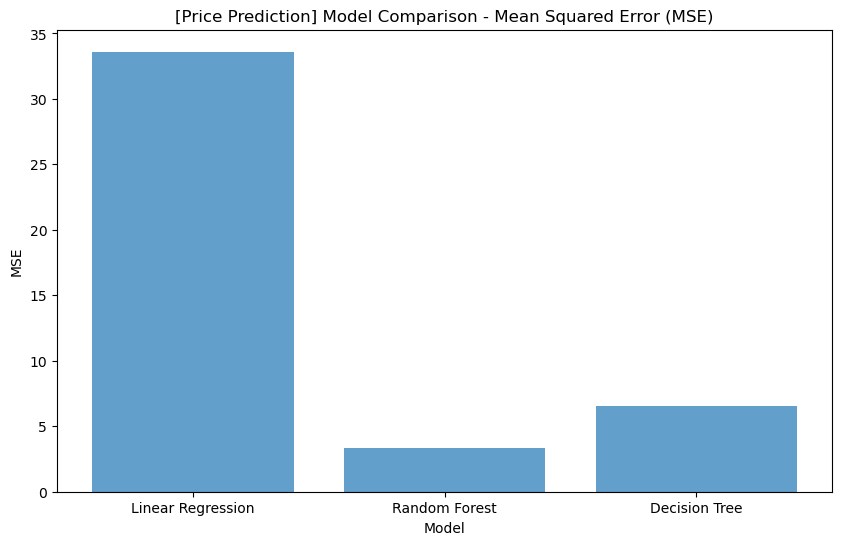

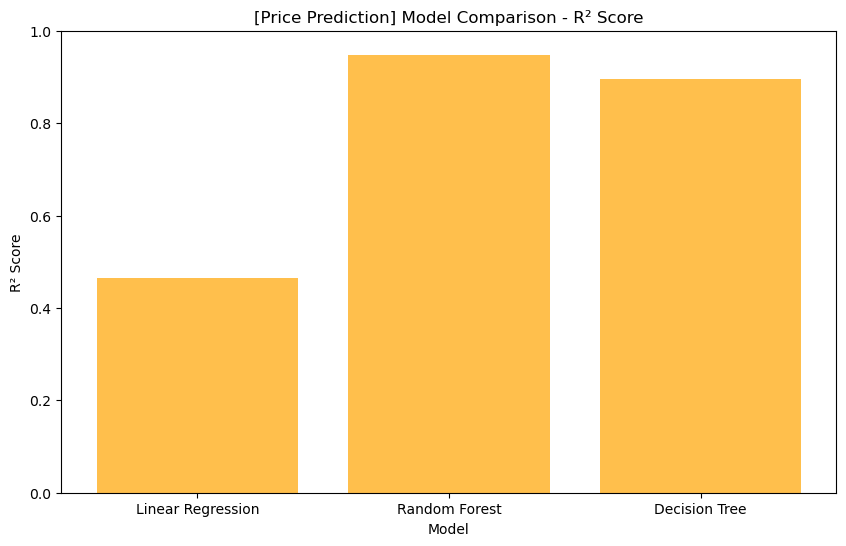

In [ ]:

# Define the models
models = ['Linear Regression', 'Random Forest', 'Decision Tree']

# Calculate MSE and R² values
mse_values = [
    mean_squared_error(y_test_uber, y_pred_linear_uber),
    mean_squared_error(y_test_uber, y_pred_rf_uber),
    mean_squared_error(y_test_uber, y_pred_dt_uber)
]
r2_values = [
    r2_score(y_test_uber, y_pred_linear_uber),
    r2_score(y_test_uber, y_pred_rf_uber),
    r2_score(y_test_uber, y_pred_dt_uber)
]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, alpha=0.7, label='MSE')
plt.title('[Price Prediction] Model Comparison - Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.xticks(models)
plt.show()

# Plot the R² values
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, alpha=0.7, color='orange', label='R² Score')
plt.title('[Price Prediction] Model Comparison - R² Score')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.xticks(models)
plt.ylim(0, 1)  # R² ranges from 0 to 1
plt.show()

### Lyft Models

In [ ]:
# Create a list of columns to encode
cols_to_encode = [col for col in lyft_data_df.columns if col not in ['price']]

# Apply label encoding to each column
for col in cols_to_encode:
    lyft_data_df[col] = label_encoder.fit_transform(lyft_data_df[col])

    # Get the mapping from encoded values to original names
    mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

    # Print the mapping for the column
    # print(f"Mapping for {col} column:")
    # print(mapping,"\n")
lyft_data_df

,source,destination,cab_type,price,distance,surge_multiplier,apparentTemperature,precipIntensity,visibility.1,precipIntensityMax,day,month,hour,minute
184332,6,11,3,7.0,84,0,248,0,6,55,12,0,3,40
167114,2,1,0,19.5,227,0,248,0,6,55,12,0,3,40
184333,6,11,5,5.0,84,0,248,0,6,55,12,0,3,40
184334,6,11,0,13.5,84,0,248,0,6,55,12,0,3,40
184335,6,11,1,19.5,84,0,248,0,6,55,12,0,3,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205379,8,1,0,16.5,201,0,23,0,167,7,11,1,19,15
290784,8,1,5,9.0,261,0,23,0,167,7,11,1,19,15
290783,8,1,4,16.5,261,0,23,0,167,7,11,1,19,15
290782,8,1,3,11.0,261,0,23,0,167,7,11,1,19,15


In [ ]:
target = 'price'
# Create feature matrix (X) and target vector (y)
X_lyft = lyft_data_df.drop('price', axis=1)
y_lyft = lyft_data_df['price']

# Convert categorical columns (e.g., is_rain, day_of_week) to numerical values
# X = pd.get_dummies(X, columns=['day_of_week', 'is_weekend'], drop_first=True)

# Split the dataset into training and testing sets
X_train_lyft, X_test_lyft, y_train_lyft, y_test_lyft = train_test_split(X_lyft, y_lyft, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
print("X_train shape:", X_train_lyft.shape)
print("X_test shape:", X_test_lyft.shape)

X_train shape: (245926, 13)
X_test shape: (61482, 13)


### Linear Regression for Lyft

In [ ]:
# Linear Regression for Uber
# Train the Linear Regression model
linear_model_lyft = LinearRegression()
linear_model_lyft.fit(X_train_lyft, y_train_lyft)

# Predict on the test set
y_pred_linear_lyft = linear_model_lyft.predict(X_test_lyft)

# Evaluate the model
print("Linear Regression Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_lyft, y_pred_linear_lyft))
print("R-squared (R2):", r2_score(y_test_lyft, y_pred_linear_lyft))
mape = mean_absolute_percentage_error(y_test_lyft, y_pred_linear_lyft) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
accuracy = r2_score(y_test_lyft, y_pred_linear_lyft) * 100
print(f"Model Accuracy (based on R²): {accuracy:.2f}%")


Linear Regression Results:
Mean Squared Error (MSE): 54.10604590470457
R-squared (R2): 0.4606320361760138


### Random forest for Lyft


In [ ]:
# Train the Random Forest model
random_forest_model_lyft = RandomForestRegressor(random_state=42, max_depth=20)
random_forest_model_lyft.fit(X_train_lyft, y_train_lyft)

# Predict on the test set
y_pred_rf_lyft = random_forest_model_lyft.predict(X_test_lyft)

# Evaluate the model
print("Random Forest Regressor Results:")
print("Mean Squared Error (MSE):", mean_squared_error(y_test_lyft, y_pred_rf_lyft))
print("R-squared (R2):", r2_score(y_test_lyft, y_pred_rf_lyft))
mape = mean_absolute_percentage_error(y_test_lyft, y_pred_rf_lyft) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
accuracy = r2_score(y_test_lyft, y_pred_rf_lyft) * 100
print(f"Model Accuracy (based on R²): {accuracy:.2f}%")


Random Forest Regressor Results:
Mean Squared Error (MSE): 1.921273379316906
R-squared (R2): 0.9808473657014866


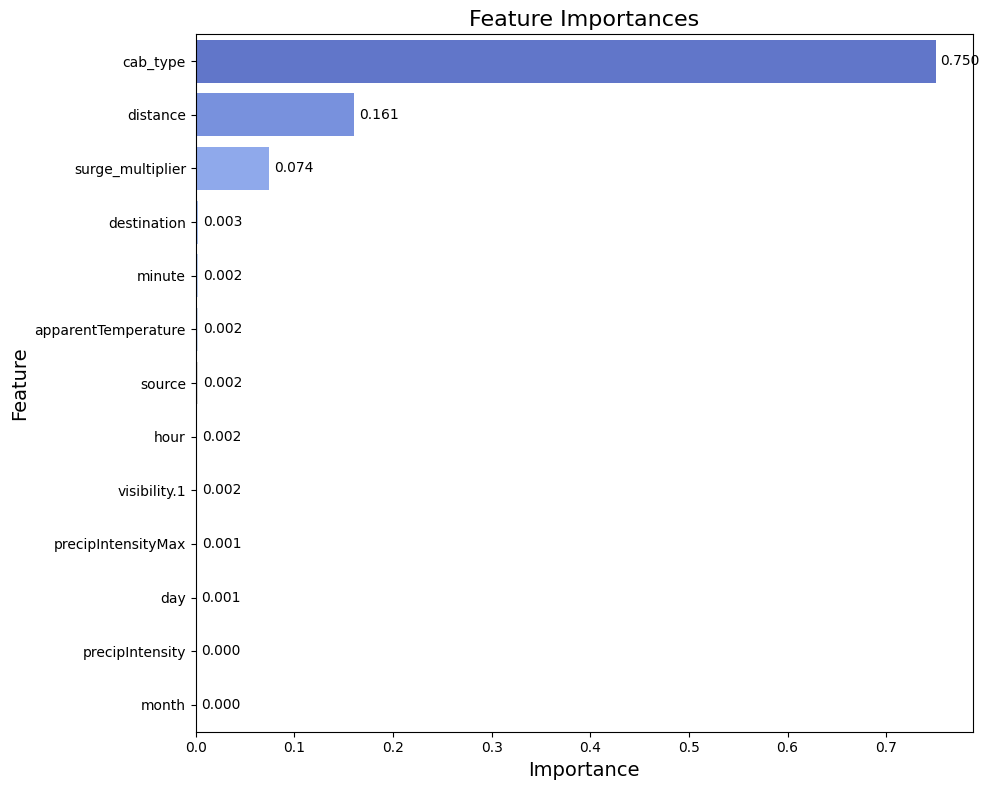

In [224]:

# Get feature importances and sort them in descending order
importances_lyft = random_forest_model_lyft.feature_importances_
feature_names_lyft = X_lyft.columns
feature_importances_lyft = pd.DataFrame({'Feature': feature_names_lyft, 'Importance': importances_lyft})
feature_importances_lyft = feature_importances_lyft.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x=feature_importances_lyft['Importance'],
    y=feature_importances_lyft['Feature'],
    palette='coolwarm' ,
    hue=feature_importances_lyft['Feature'],
    dodge=False,
    legend=False
)
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add annotations to each bar
for i, v in enumerate(feature_importances_lyft['Importance']):
    plt.text(v + 0.005, i, f"{v:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Decision Regressor for Lyft


In [225]:
# Decision Regressor Model for Lyft
dt_model_lyft = DecisionTreeRegressor(random_state=42)
dt_model_lyft.fit(X_train_lyft, y_train_lyft)
y_pred_dt_lyft = dt_model_lyft.predict(X_test_lyft)

mae = mean_absolute_error(y_test_lyft, y_pred_dt_lyft)
mse = mean_squared_error(y_test_lyft, y_pred_dt_lyft)
r2 = r2_score(y_test_lyft, y_pred_dt_lyft)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
mae = mean_absolute_percentage_error(y_test_lyft, y_pred_dt_lyft) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
accuracy = r2_score(y_test_lyft, y_pred_dt_lyft) * 100
print(f"Model Accuracy (based on R²): {accuracy:.2f}%")


# Optional: Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train_lyft.columns,
    'Importance': dt_model_lyft.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

Mean Absolute Error (MAE): 1.0933652125825444
Mean Squared Error (MSE): 3.6335568018101054
R² Score: 0.963778093540916

Feature Importances:
                Feature  Importance
2              cab_type    0.746423
3              distance    0.160794
4      surge_multiplier    0.073585
12               minute    0.003466
5   apparentTemperature    0.002969
1           destination    0.002909
0                source    0.002287
11                 hour    0.002174
7          visibility.1    0.002118
8    precipIntensityMax    0.001402
9                   day    0.001229
6       precipIntensity    0.000530
10                month    0.000115


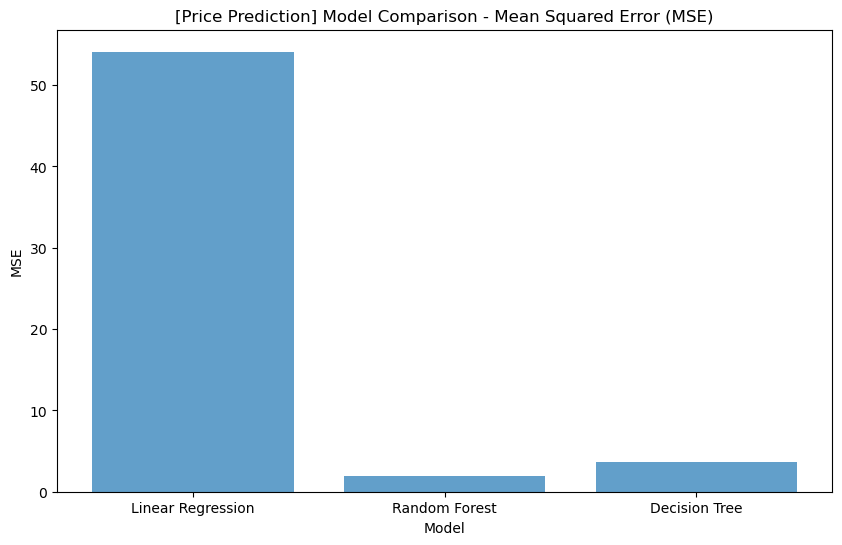

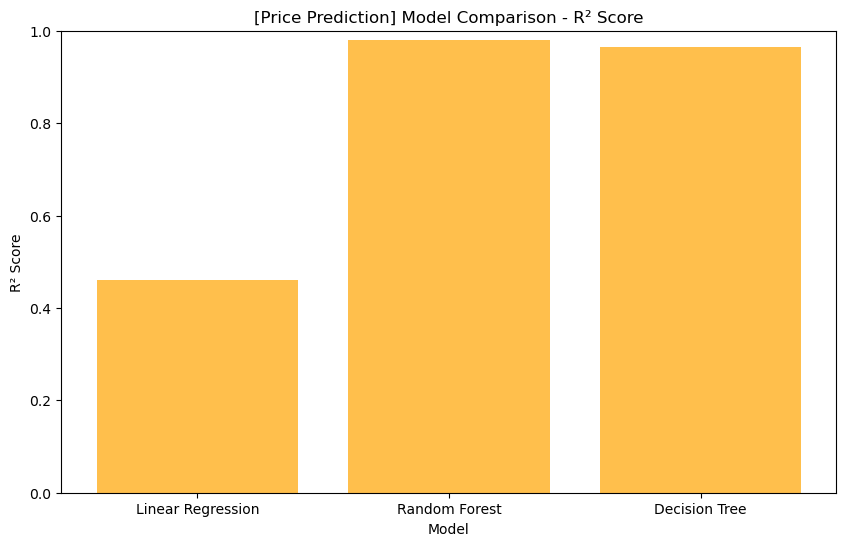

In [ ]:
# Model Comparison for Lyft
# Define the models
models = ['Linear Regression', 'Random Forest', 'Decision Tree']

# Calculate MSE and R² values
mse_values = [
    mean_squared_error(y_test_lyft, y_pred_linear_lyft),
    mean_squared_error(y_test_lyft, y_pred_rf_lyft),
    mean_squared_error(y_test_lyft, y_pred_dt_lyft)
]
r2_values = [
    r2_score(y_test_lyft, y_pred_linear_lyft),
    r2_score(y_test_lyft, y_pred_rf_lyft),
    r2_score(y_test_lyft, y_pred_dt_lyft)
]

# Plot the MSE values
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, alpha=0.7, label='MSE')
plt.title('[Price Prediction] Model Comparison - Mean Squared Error (MSE)')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.xticks(models)
plt.show()

# Plot the R² values
plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, alpha=0.7, color='orange', label='R² Score')
plt.title('[Price Prediction] Model Comparison - R² Score')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.xticks(models)
plt.ylim(0, 1)  # R² ranges from 0 to 1
plt.show()

## Model Usage Helper Functions

In [210]:

# Features and target
X_func = golden_data[['cab_company', 'cab_type', 'surge_multiplier', 'distance']]
y_func = golden_data['price']

# Split the data into training and testing sets
X_train_func, X_test_func, y_train_func, y_test_func = train_test_split(X_func, y_func, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
random_forest_model.fit(X_train_func, y_train_func)

# Make predictions on the test set
y_pred_func = random_forest_model.predict(X_test_func)

# Evaluate the model
mse = mean_squared_error(y_test_func, y_pred_func)
r2 = r2_score(y_test_func, y_pred_func)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Function to predict price based on 4 input features
def predict_cab_price(cab_company, cab_type, surge_multiplier, distance):
    # Map inputs to an array based on feature order
    x_input = [cab_company, cab_type, surge_multiplier, distance]
    return random_forest_model.predict([x_input])[0]

# Example usage to predict the price
cab_company = 0  # 0 for 'Uber'
cab_type = 1     # 1 for 'UberX'
surge_multiplier = 1.3
distance = 10.5

predicted_price = predict_cab_price(cab_company, cab_type, surge_multiplier, distance)
print(f"Predicted Cab Price: ${predicted_price:.2f}")

Mean Squared Error (MSE): 2.7531933507446182
R-squared (R2): 0.9654965563062645
Predicted Cab Price: $20.18


/Users/ayushshah/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
